In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy import constants


### discretized k_n
def get_k(n,L):
    return n * np.pi / L

### solutions to the time-independent Schroedinger equations
def phi(x,n,L):
    if n%2 == 0:
        return np.sqrt(2./L) * np.sin( get_k(n,L) * x)
    else:
        return np.sqrt(2./L) * np.cos( get_k(n,L) * x)

### dispersion relation
def omega(n,L,m):
    return get_k(n,L)**2 * constants.hbar / m

### calculate a_n by projecting the initial condition onto the eigenfunctions phi_n
def get_a_n(init, phi_matrix, dx):
    n_max = phi_matrix.shape[0]
    a_n = np.zeros(n_max, dtype = complex)
    for n in range(n_max):
        a_n[n] = init @ phi_matrix[n] * dx
    return a_n
        
### calculate the time evolution of the wavefunction Psi.
def get_Psi(init, a_n_max, tmax, t_nmax):
    
    x_nmax = init.size
    t = np.linspace(0,t_max,t_nmax)

    ### fill phi matrix
    phi_matrix = np.zeros((a_n_max,x_nmax))
    for n in range(a_n_max):
        phi_matrix[n] = phi(x,n+1,L) #no n=1 state
    
    ### project intitial condition onto the modes
    a_n = get_a_n(init,phi_matrix,dx)
    
    ### calculate the time evolution of the wavefunction
    Psi = np.zeros((t_nmax,x_nmax), dtype=complex)
    for t_n in range(t_nmax):
        psi = np.zeros(x_nmax, dtype=complex)
        for n in range(a_n_max):
            psi += a_n[n] * phi_matrix[n] * np.exp(1.j * omega(n,L,m) * t[t_n])
        Psi[t_n] = psi
        
    return Psi

<IPython.core.display.Javascript object>


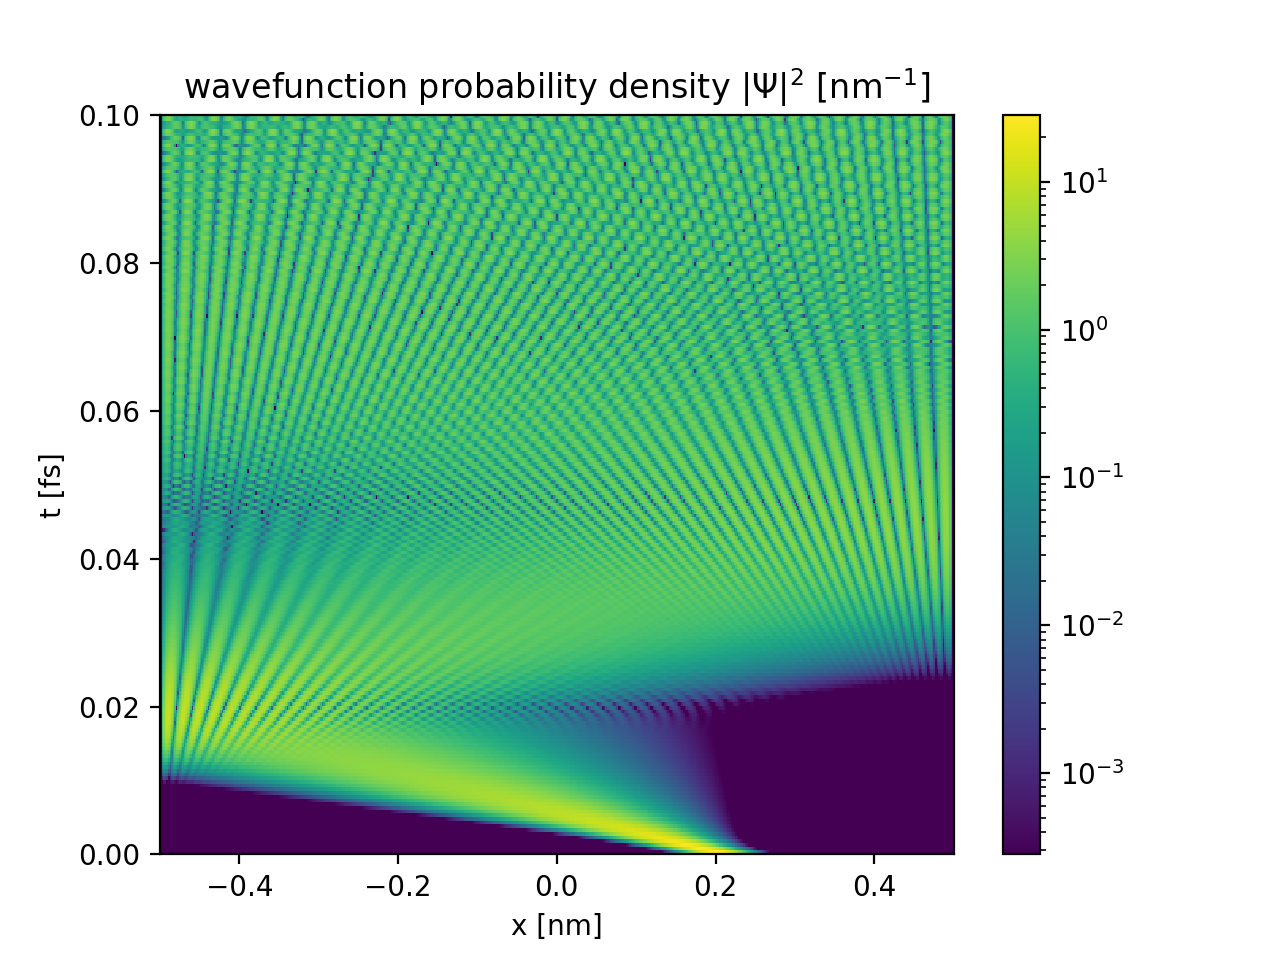

In [36]:
### model parameters
L = 1.0e-9 # 1nm
m = constants.m_e # electron mass

#### spatial discretization
x_nmax = 500

### number of modes
a_n_max = 200

### integration time and number of samples
t_max = 0.1e-15 # e-15 -> femto seconds
t_nmax = 200

### Gaussian initial condition paramters ###
x_0 = L/5 #mean
sigma = L/50 #width
k = get_k(50,L) #mean wave vector

### calc initial condition###
x = np.linspace(-L/2.,L/2.,x_nmax+1, endpoint = True) #spatial grid
dx = L/x_nmax #spatial discretization length

init = np.exp(-0.25 * (x-x_0)**2 / sigma**2 )**2 * np.exp(1.j*k*x)
norm = (np.sum( np.abs(init)**2 )*dx)
init /= np.sqrt(norm)
# print(np.sum(np.abs(init)**2)*dx) # make sure the norm works


from matplotlib.colors import LogNorm

Psi = get_Psi(init, a_n_max, t_max, t_nmax)
Psi2 = np.abs(Psi)**2

extent_ar = [-L/2*1e9, L/2*1e9, 0*1e15,t_max*1e15]
plt.imshow(Psi2*1e-9, aspect='auto', interpolation='none', origin='lower', norm=LogNorm(vmin=1e-5*Psi2.max()*1e-9), extent = extent_ar)
plt.xlabel('x [nm]')
plt.ylabel('t [fs]')
plt.title(r'wavefunction probability density $|\Psi|^2$ [nm$^{-1}$]')
plt.colorbar()
plt.show()



<IPython.core.display.Javascript object>


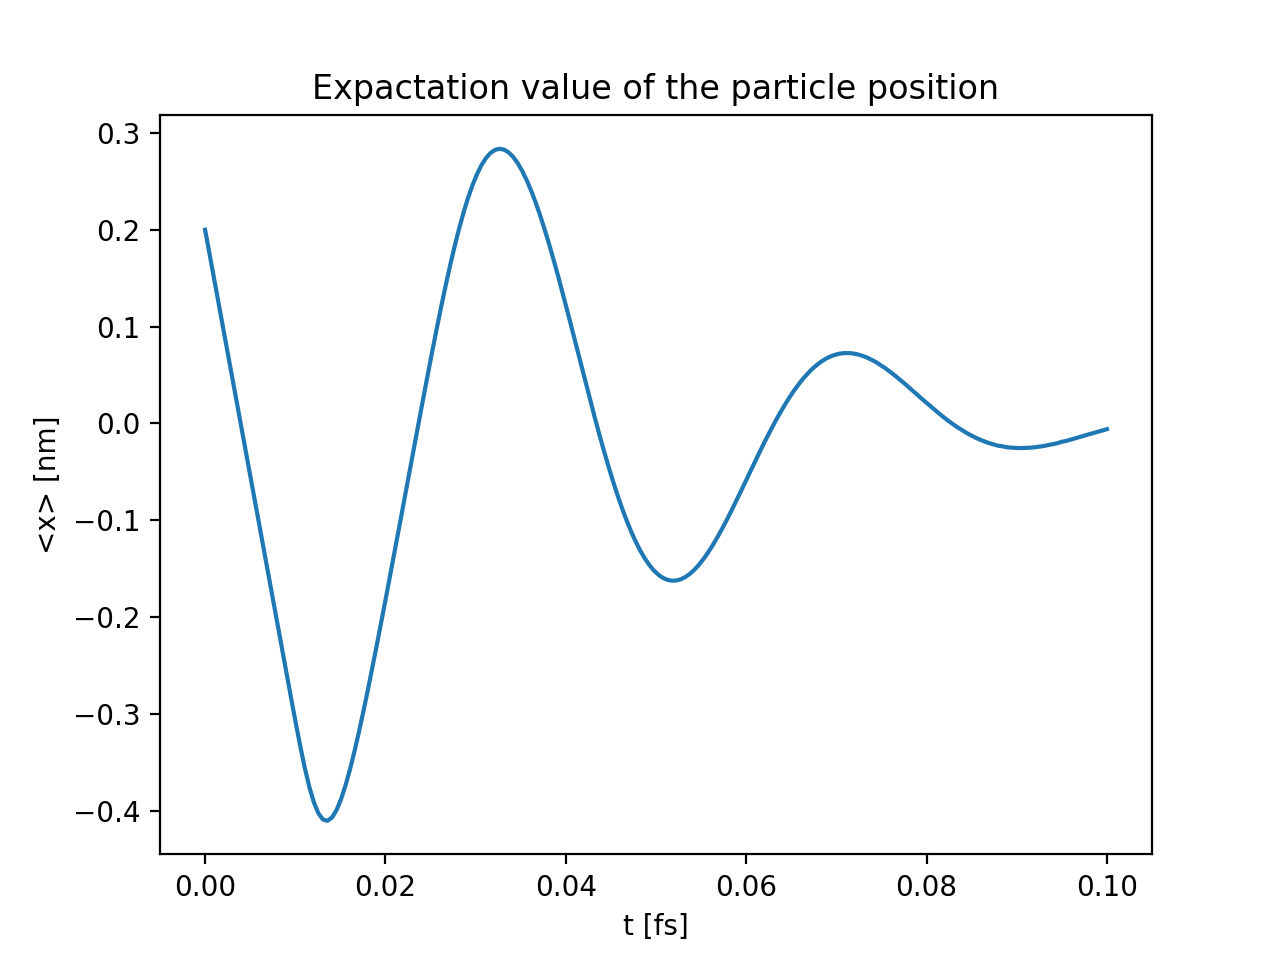

In [30]:
x_mean = np.sum(Psi2 * x, axis=1)*dx
plt.plot(np.linspace(0,t_max,t_nmax)*1e15,x_mean*1e9)
plt.title('Expactation value of the particle position')
plt.xlabel('t [fs]')
plt.ylabel('<x> [nm]')
plt.show()

<IPython.core.display.Javascript object>


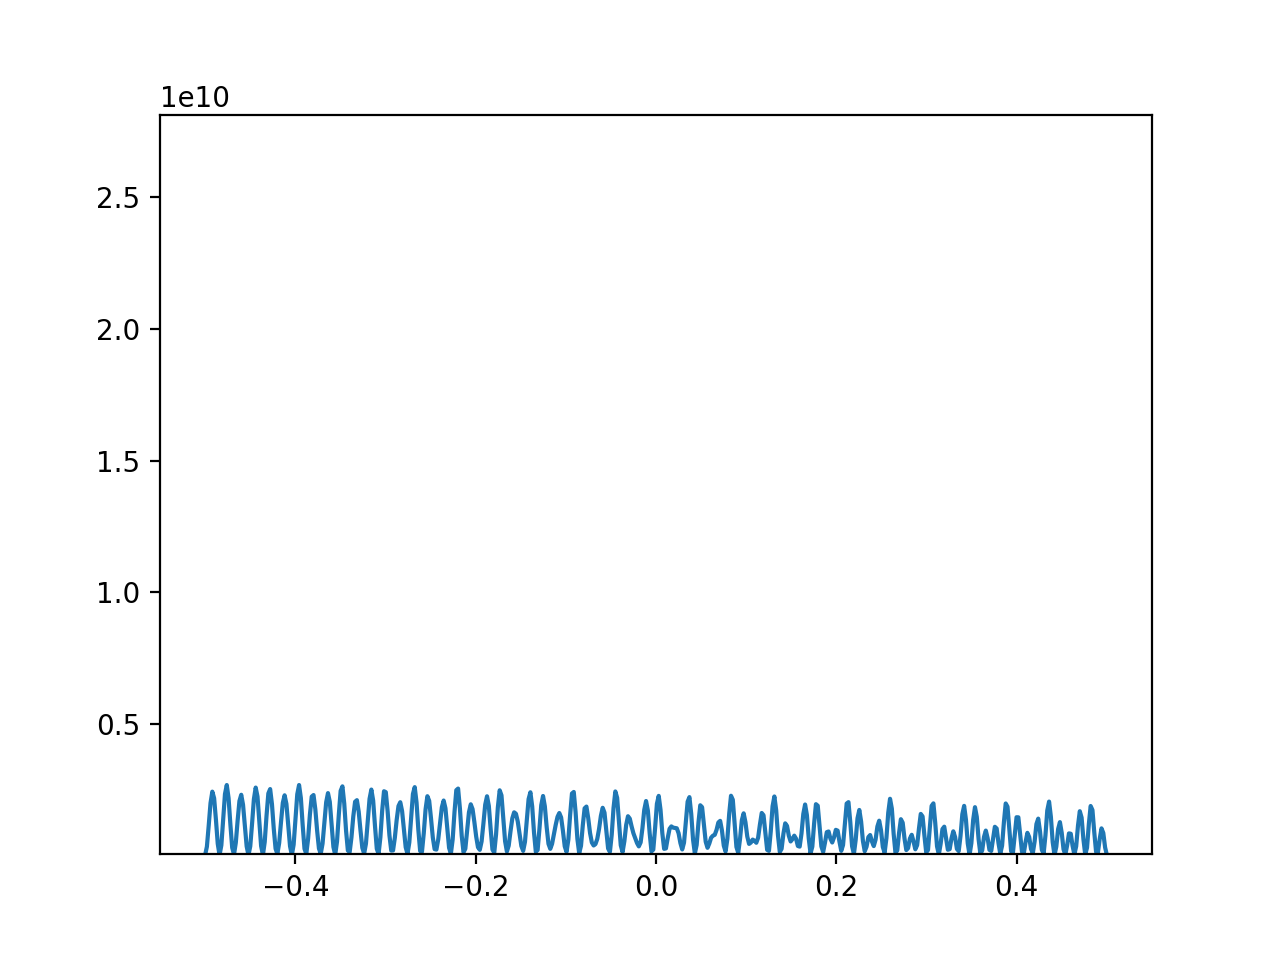

In [20]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

line, = ax.plot([]) 

ax.set_xlim(x.min()*1e9, x.max()*1e9)
ax.set_ylim(1e-3*Psi2.max(),Psi2.max())

def animate(frame_num):
    plt.cla()
    plt.plot(x*1e9,Psi2[frame_num])
    plt.ylim(1e-3*Psi2.max(),Psi2.max())

anim = FuncAnimation(fig, animate, frames=t_nmax, interval=10)

plt.show()

<IPython.core.display.Javascript object>


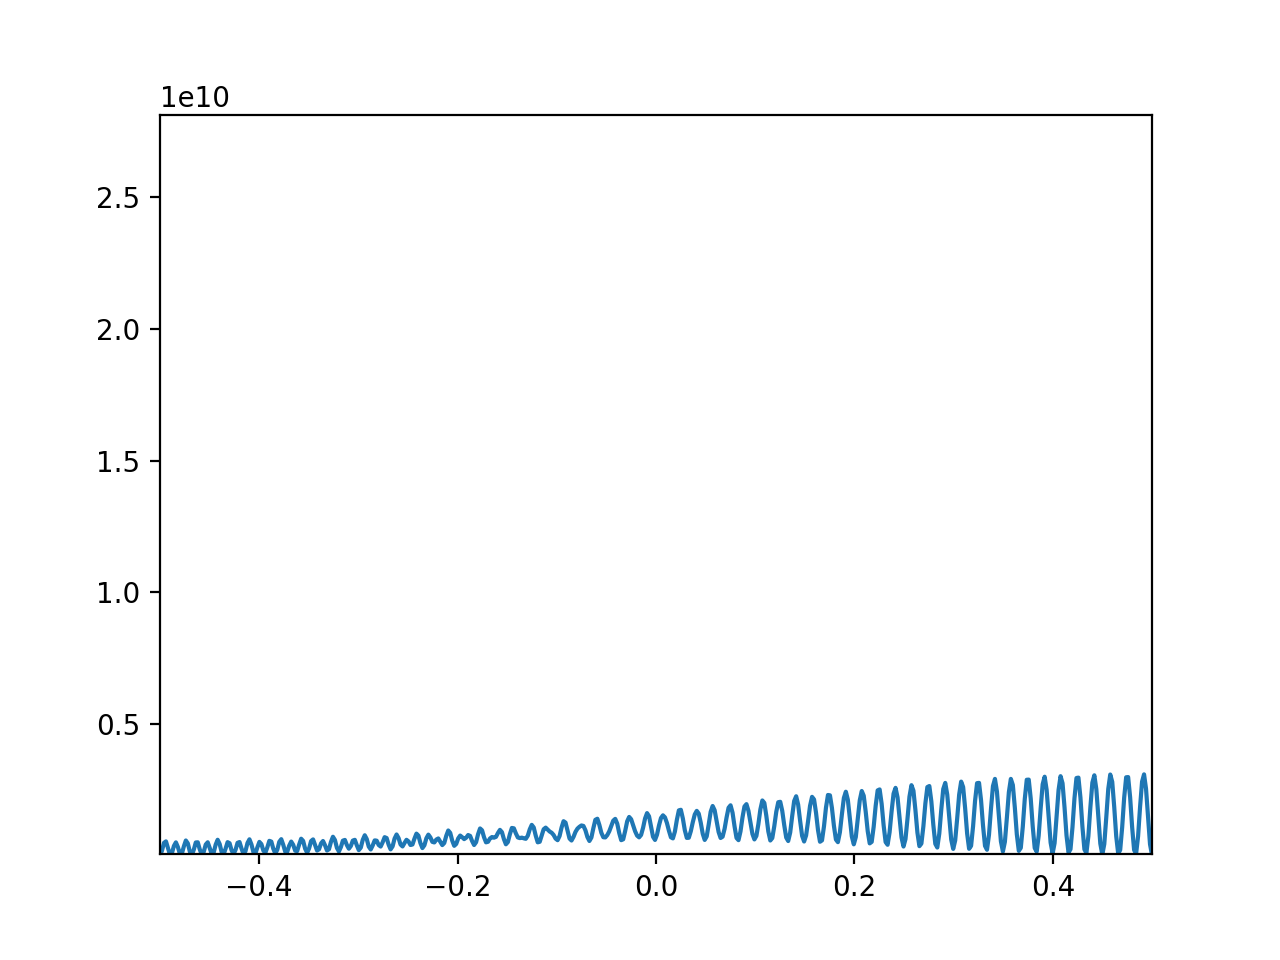

In [19]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

line, = ax.plot([]) 

ax.set_xlim(x.min()*1e9, x.max()*1e9)
ax.set_ylim(1e-3*Psi2.max(),Psi2.max())

def animate(frame_num):
    line.set_data((x*1e9, Psi2[frame_num]))
    return line

anim = FuncAnimation(fig, animate, frames=t_nmax, interval=10)

plt.show()